## Chromaffin dataset - $\kappa$-velo

**In this Notebook we will be applying $\kappa$-velo on the chromaffin dataset. This dataset was originally published by Furlan et al. (https://doi.org/10.1126/science.aal3753). The dataset was used for RNA velocity for the first time by La Manno et al. (https://doi.org/10.1038/s41586-018-0414-6). This dataset was generated using SMART-seq2 and shows mouse Schwann cell precursors (SCPs) differentiating into chromaffin cells.** 

In [58]:
### load libraries

# standard libraries
import numpy as np
import pandas as pd

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree 

# import our own functions
import velocity

## Load dataset
First, load the spliced and unspliced matrices from the original dataset, as well as the annotation (original clusters), colours and t-SNE embedding. All of the files used here can be downloaded from [here](http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html) (a tutorial on velocyto provided by La Manno and the Karchenko lab). The original file name is `onefilepercell_A1_unique_and_others_J2CH1.loom `, which we renamed to `chromaffin.loom`. The files with the cell colors/clusters (`cell_colors.csv`) and the t-SNE embedding (`embedding.csv`) can be found under datasets/chromaffin.

In [59]:
### load chromaffin dataset
chromaffin_path = "../datasets/chromaffin/chromaffin.loom"
adata = ad.read_loom(chromaffin_path)

In [60]:
### make obs names shorter
new_names = []

for obs_name_idx in range(len(adata.obs_names)):
    obs_name = adata.obs_names[obs_name_idx]
    new_name = obs_name.replace("onefilepercell_A1_unique_and_others_J2CH1:", "")
    new_name = new_name.replace("_unique.bam", "")
    new_names.append(new_name)

adata.obs_names = new_names

In [4]:
### add clusters from original publication
clusters_path ="../datasets/chromaffin/cell_colors.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
adata = adata[clusters.index,:]
adata.obs["clusters"] = clusters

Trying to set attribute `.obs` of view, copying.


In [5]:
### set correct names and colours to clusters
cluster_names = {'#00FF66FF':'0','#0066FFFF':'1','#CC00FFFF':'2','#CCFF00FF':'3','#FF0000FF':'4'}
adata.obs['clusters'] = (adata.obs['clusters'].map(cluster_names).astype('category'))
adata.uns['clusters_colors'] = ['#00FF66FF','#0066FFFF','#CC00FFFF','#CCFF00FF','#FF0000FF']

In [6]:
### add embedding from original publication
embedding_path = "../datasets/chromaffin/embedding.csv"
embedding = pd.read_csv(embedding_path, index_col=0)
adata = adata[embedding.index,:]
adata.obsm["X_tsne"] = embedding
adata.obsm["X_tsne"] = np.array(adata.obsm["X_tsne"])

/Users/vmarotl/bin/miniconda3/envs/clone/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Chromosome' as categorical
/Users/vmarotl/bin/miniconda3/envs/clone/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Strand' as categorical


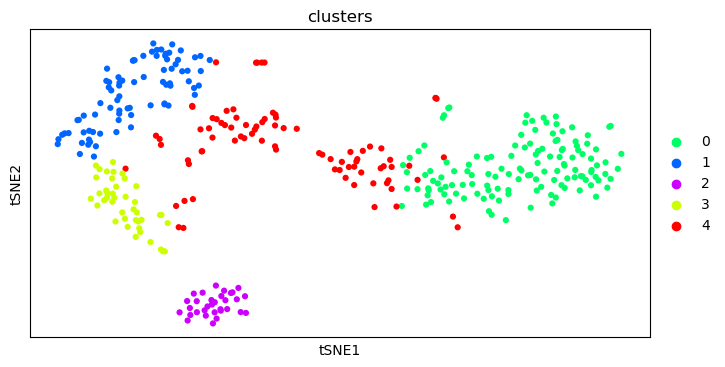

In [7]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(8, 4), frameon=False)
sc.pl.tsne(adata, color="clusters", s=80, ax=axs)

In [61]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

## Prepare the data

Process the dataset for $\kappa$-velo analysis. Please refer to our [preprint](https://doi.org/10.1101/2022.03.17.484754If) to know more about processing. 

- (1) select HVGs, using analytic Pearson residuals [(Lause et al., 2021)](https://doi.org/10.1186/s13059-021-02451-7).
- (2) filter genes with too low unspliced / spliced counts
- (3) normalise data
- (4) impute u, s counts

#### (1) HVGs

In [10]:
### select HVGs
hvgs = velocity.pp.filtering.get_hvgs(adata, no_of_hvgs=2000, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

Subsetting to top 2000 highly-variable genes.


/Users/vmarotl/Documents/rna_velocity/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


#### (2) filtering

In [11]:
### subset for genes that have high enough U and S counts
minlim = 15
us_genes = velocity.pp.filtering.get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 1894 genes with sufficient S and U counts.


#### (3) normalisation

In [12]:
### L1 normalise unspliced and spliced together
velocity.pp.normalisation.normalise_layers(adata, mode='combined', norm='L1')

total_counts not given


#### (4) imputation

In [13]:
### imputation
velocity.pp.imputation.impute_counts(adata, n_neighbours = 15, layer_NN = 'spliced', n_pcs = 15)

## Recover reaction rate parameters

To recover the parameters, we run the function `recover_reaction_rate_pars`. This function takes some time (so to save some time you can also just download the recovered parameters and add them to the AnnData object. 

In [14]:
### recover dynamics for selected genes
#velocity.tl.fit.recover_reaction_rate_pars(adata, use_raw=False, n=100, key="fit")

In [15]:
### save recovered parameters
#save_path = "../datasets/chromaffin/adata_var_after_recovery.csv"
#adata.var.to_csv(save_path)

In [16]:
### load recovered parameters
load_path = "../datasets/chromaffin/adata_var_after_recovery.csv"
adata.var = pd.read_csv(load_path, index_col=0)

## Filter genes

- (1) Likelihood filtering: After recovery of the reaction rate parameters for all genes, we get the likelihood of the fit. For genes with low likelihoods, the recovered velocities will have a lot of errors. Because of this we exclude these genes
- (2) Prior knowledge filtering: If we know the temporal order of cluster, we can use it as prior knowledge for an additional filtering round if the fitted state assignments do not fit the state assignments from prior knowledge.

#### (1) Likelihood filtering

In [17]:
### remove likelihood genes
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes = likelihood_genes.dropna()
likelihood_genes = likelihood_genes[likelihood_genes > 0.7]
likelihood_genes = likelihood_genes.index.values
print(str(len(likelihood_genes))+" high-likelihood genes kept")
adata = adata[:, likelihood_genes]

606 high-likelihood genes kept


#### (2) prior knowledge filtering

In [ ]:
### set prior state on genes (second entry is the cluster preceding the first entry)
connections_dict = {'0': ['4'],
                    '4': ['1'],
                    '2': ['1'],
                    '3': ['1']}

velocity.tl.prior.set_prior_state(adata, connections_dict, clusterkey="clusters")

In [19]:
### find all genes where prior state matches the retrieved state
matching_genes = velocity.tl.filtering.get_matching_state_genes(adata, total_cells=30, perc_cells=5, perc_match=80)
print(str(len(matching_genes))+" prior state matching genes kept")
adata = adata[:, matching_genes]

116 prior state matching genes kept


/Users/vmarotl/Documents/rna_velocity/velocity_package/velocity/tools/filtering.py:44: RuntimeWarning: invalid value encountered in true_divide
  percentage = (prior_ks == method_ks).sum()/total_cells_with_prior*100


## Calculate velocities


In [20]:
### calculate velocity
velocity.tl.fit.get_velocity(adata, use_raw=False, key="fit", normalise=None, scale=True)

Trying to set attribute `.layers` of view, copying.


## Plot velocities in low-dimensional embedding

We can visualise the velocities on different types of low dimensional embedding:
- (1) PCA
- (2) UMAP

#### (1) PCA

In [34]:
velocity.project.pca.pca_project(adata, n_pcs=30)

Variance and mean stabilisation of count matrix for PCA.
Calculating PCA.
Projecting future states.
Saving to annData object.


In [45]:
adata.obsm["velocity_pca"]*=3
pca_v=adata.obsm["velocity_pca"]
pca_pts=adata.obsm["X_pca"]

In [46]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
cell_colors=adata.obs["clusters"].map(color_dict)
light_color = np.array([velocity.pl.utils.lighten_color(i, .3) for i in cell_colors])

In [47]:
kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k", "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

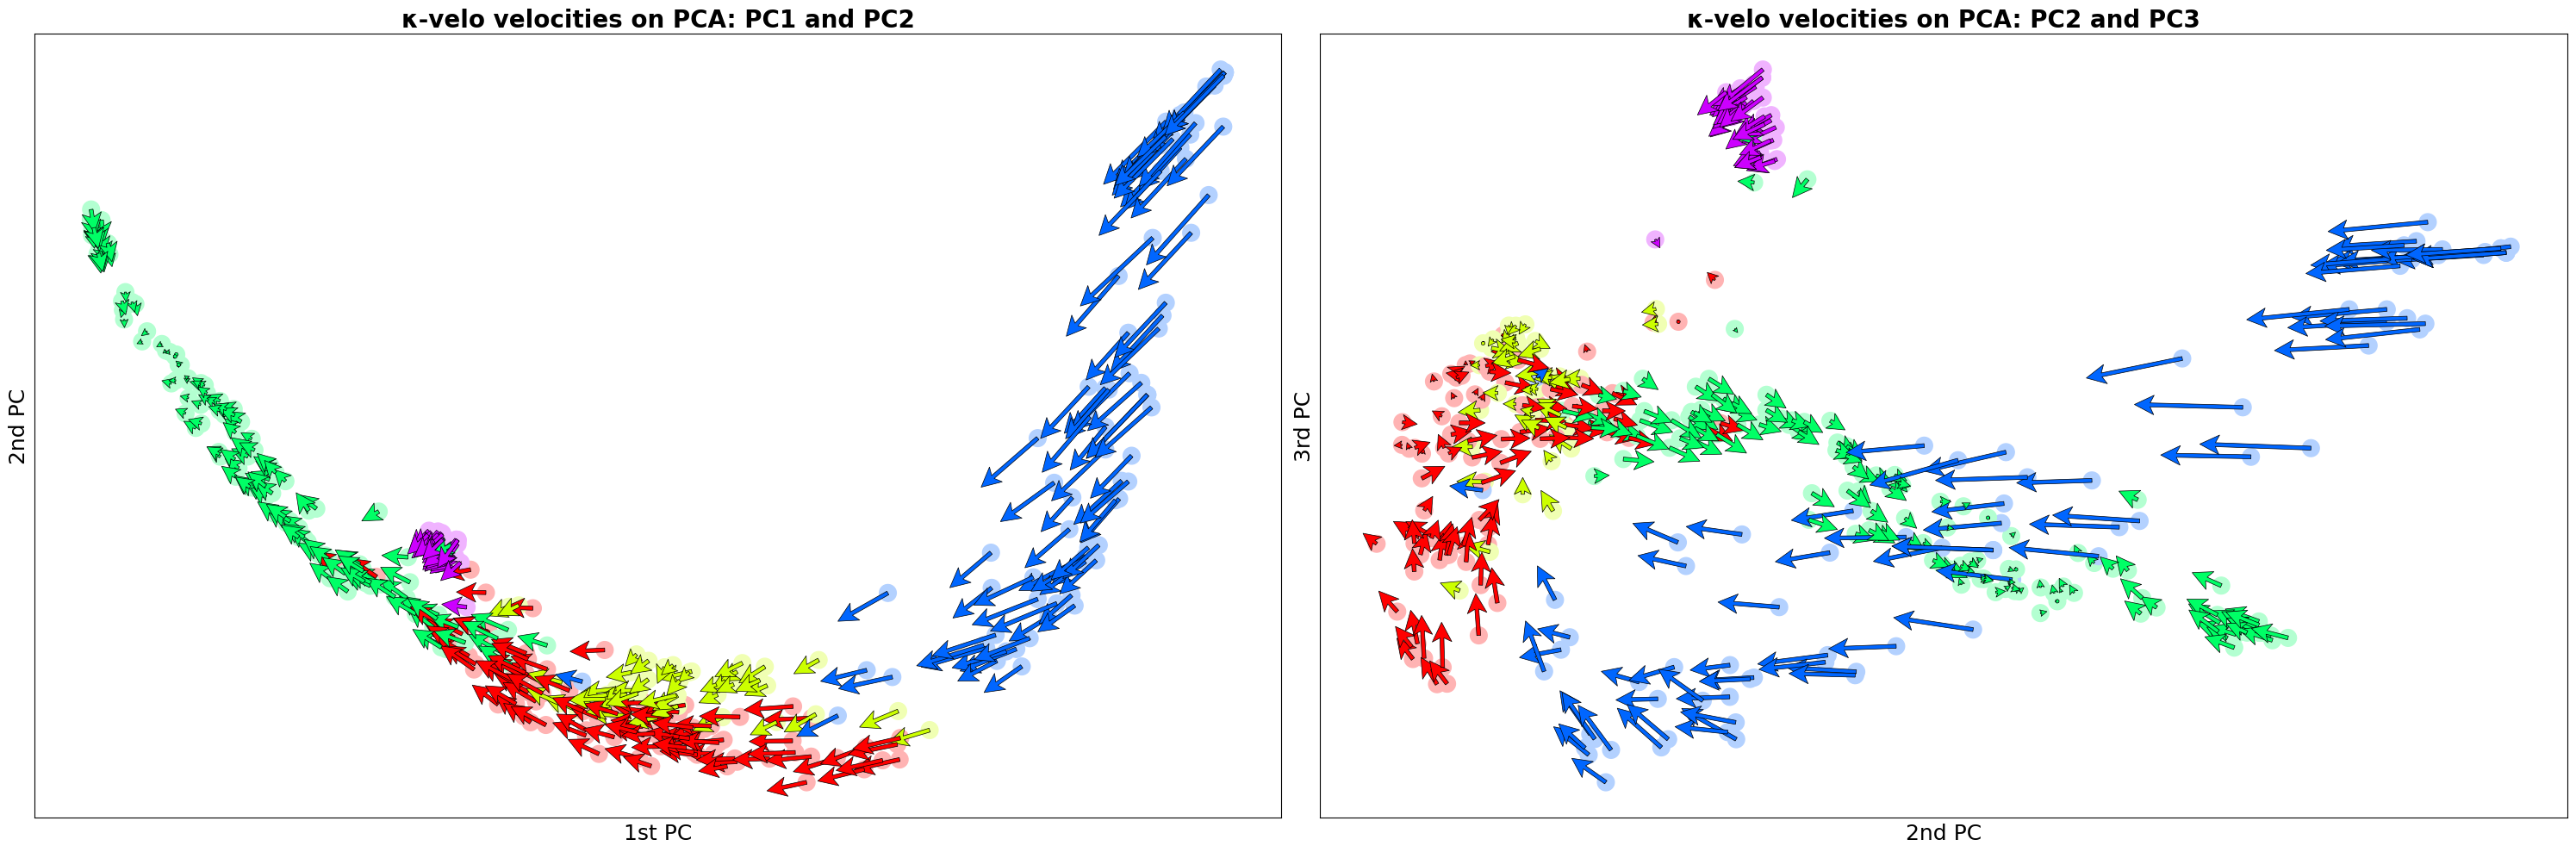

In [48]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=200)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("1st PC", fontsize=18)
axs[0].set_ylabel("2nd PC", fontsize=18)
axs[1].set_xlabel("2nd PC", fontsize=18)
axs[1].set_ylabel("3rd PC", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on PCA: PC1 and PC2", fontsize=20, fontweight="bold")
axs[1].set_title("κ-velo velocities on PCA: PC2 and PC3", fontsize=20, fontweight="bold")

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v[:,0], pca_v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v[:,1], pca_v[:,2], color=cell_colors, **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/chromaffin/chromaffin_kappa-velo_PCA.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

#### (2) UMAP embedding

In [49]:
### calculate UMAP 
reducer = umap.UMAP(random_state=0, n_neighbors=20, min_dist=.7, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

# save UMAP to annData object
adata.obsm["X_umap"]=UMAP_data

In [54]:
### calculate velocity projections
velocity.project.nystroem.nystroem_project(adata, basis="umap", n_neighbors=15)
UMAP_v = adata.obsm["velocity_umap"]

Projecting velocities using Nyström approach.
Saving to annData object.


**Smoothen velocities**

In [55]:
### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

<ipython-input-55-fb12c6d4a1d7>:2: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]


In [56]:
### smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v)[NN], axis=1)

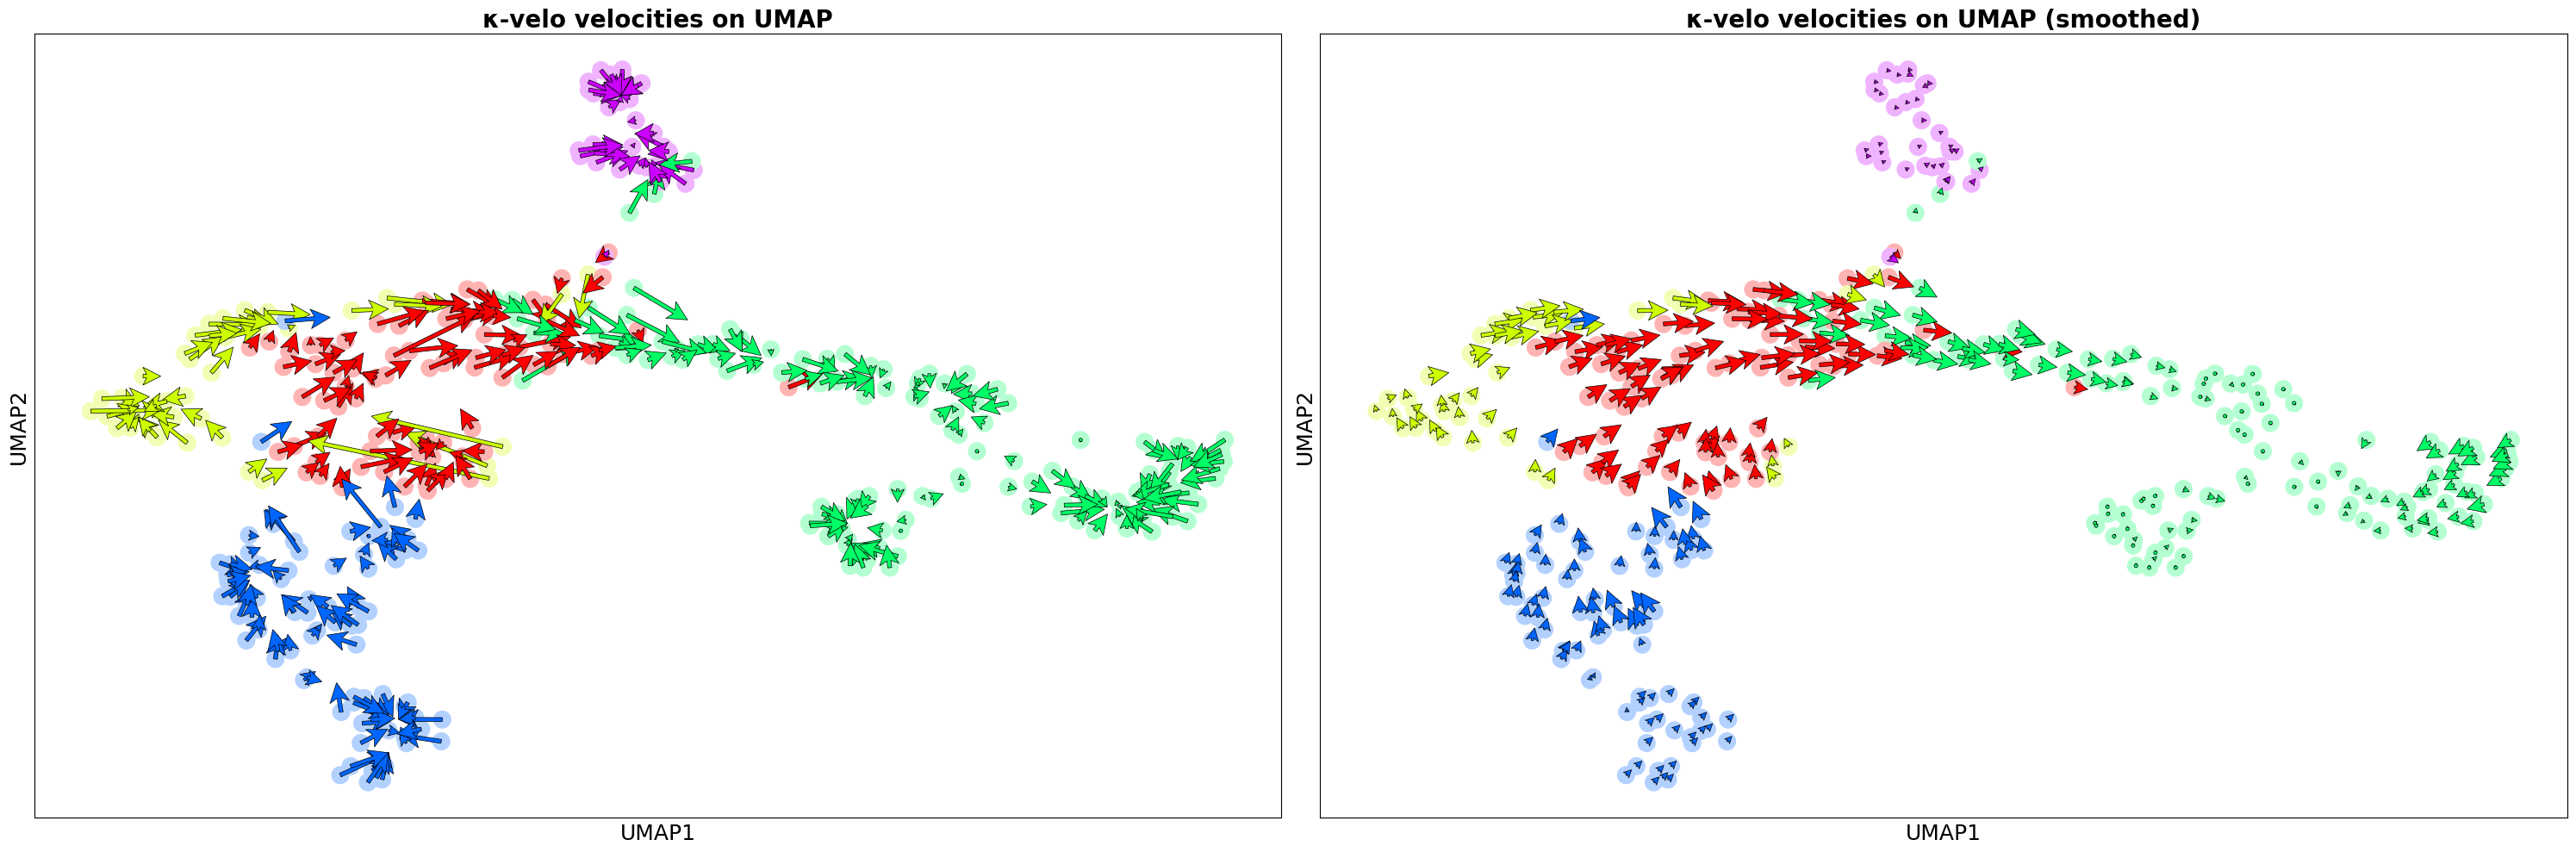

In [57]:
### create UMAP plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)
axs[1].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("UMAP1", fontsize=18)
axs[0].set_ylabel("UMAP2", fontsize=18)
axs[1].set_xlabel("UMAP1", fontsize=18)
axs[1].set_ylabel("UMAP2", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on UMAP", fontsize=20, fontweight="bold")
axs[1].set_title("κ-velo velocities on UMAP (smoothed)", fontsize=20, fontweight="bold")

# plot arrows 
axs[0].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v[:,0], UMAP_v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v_mean[:,0], UMAP_v_mean[:,1], color=cell_colors, **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/chromaffin/chromaffin_kappa-velo_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()